# K-Means 算法：局部最优特性
---


In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

首先我们定义数据点为

$ A(0,0)，B(2,2)，C(3,3)，D(5,5) $

将结果保存到内存中，使用 numpy 数组保存

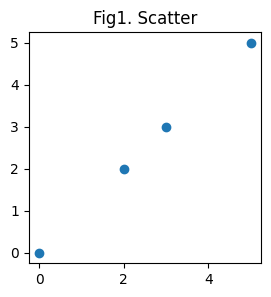

In [2]:
x = [[0,0],[2,2],[3,3],[5,5]]
X = np.array(x)

plt.figure(figsize=(3,3))
plt.title("Fig1. Scatter")
plt.scatter(X[:,0], X[:,1])
plt.show()

这时候我们的 data 维度是 $ (4,2) $，令 $ K = 2 $ 随机从里面选两个点出来

In [3]:
c = random.sample(x, 2)
pf = pd.DataFrame(c, columns=['X', 'Y'], index=['C{}'.format(i+1) for i in range(2)])
pf

,X,Y
C1,5,5
C2,2,2


我们也可以固定两个点作为起点

In [4]:
c = [[0,0], [5,5]]

逐个进行求 $R^2$ 空间内的距离 $d(x_i, c_i) = \sum_{x_i ∈ X, c_i ∈ C} \sqrt{|| c_i - x_i ||^2}$

我们先规定我们的数据

$ X =  \begin{bmatrix}
0 & 0 \\
2 & 2 \\
3 & 3 \\
5 & 5 \\
\end{bmatrix}$ ，
$ K = \begin{bmatrix}
r_x & r_y 
\end{bmatrix}$ ，
$
S = \begin{bmatrix}
1 \\
1
\end{bmatrix}
$

实际运算中，会自动进行形状适配，对维度为 $1$ 的部分进行扩充

计算 $ E_i = \sqrt{(X - K_i)^2 \cdot S}，其中 K_i∈K$

In [5]:
# 用起来不方便, 建立一个映射表
idx2alpha, alpha2idx = {}, {}
alpha = ['A', 'B', 'C', 'D']

for idx, al in enumerate(alpha):
    idx2alpha[idx] = al
    alpha2idx[al] = idx

S, E = np.ones((2,1)), []

for kernel in c:
    K = np.array(kernel)
    E.append(np.sqrt((X - K)**2 @ S))

E = pd.DataFrame(np.concatenate(E, axis=1), columns=['C{}'.format(i+1) for i in range(2)], index=alpha)
E

,C1,C2
A,0.000000,7.071068
B,2.828427,4.242641
C,4.242641,2.828427
D,7.071068,0.000000


这样我们就获得了距离数据 $E$，之后我们进行归类，获取最小值的 index

In [6]:
T = pd.DataFrame(E.idxmin(axis=1), columns=['Class'])
T.T

,A,B,C,D
Class,C1,C1,C2,C2


我们分别把 $C1、C2$ 求出来

In [7]:
C1 = pd.DataFrame(x, columns=['X', 'Y'], index=alpha).loc[T[T['Class'] == 'C1'].index]
C1

,X,Y
A,0,0
B,2,2


In [8]:
C2 = pd.DataFrame(x, columns=['X', 'Y'], index=alpha).loc[T[T['Class'] == 'C2'].index]
C2

,X,Y
C,3,3
D,5,5


求最新的中心点 $ x_i = \frac{\sum_{C_j∈C_i} x_j}{N}，y_i = \frac{\sum_{C_j∈C_i} y_j}{N}，其中 N 为该分类点数$

In [9]:
C = pd.DataFrame([C1.mean().values, C2.mean().values], columns=['X', 'Y'], index=['C1','C2'])
C

,X,Y
C1,1.0,1.0
C2,4.0,4.0


这样我们就计算出来了最新的中心点位置，我们绘制出来

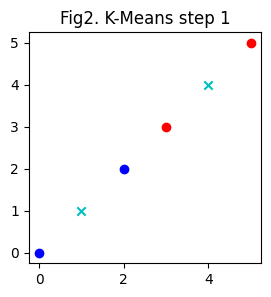

In [10]:
x = [[0,0],[2,2],[3,3],[5,5]]
X = np.array(x)

plt.figure(figsize=(3,3))
plt.title("Fig2. K-Means step 1")
plt.scatter(C1['X'], C1['Y'], c='b')
plt.scatter(C2['X'], C2['Y'], c='r')
plt.scatter(C['X'], C['Y'], marker='x', c='c')
plt.show()

其中蓝色是类型 $C1$ 青色是 $C2$，红色为我们的中心点

我们开始整理成函数并一直执行，直到中心点不再更新

---------------------------------------------------------
     X  Y
C1  3  3
C2  0  0 

            X         Y
C1  3.333333  3.333333
C2  0.000000  0.000000
---------------------------------------------------------
            X         Y
C1  3.333333  3.333333
C2  0.000000  0.000000 

            X         Y
C1  3.333333  3.333333
C2  0.000000  0.000000
---------------------------------------------------------
K-Means: 中心点不再移动


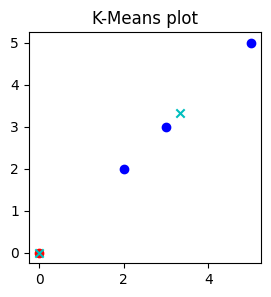

,X,Y
C1,3.333333,3.333333
C2,0.000000,0.000000


In [11]:
class Kmeans():
    '''
    K-Means 算法类, 直接管理所有算法
    '''
    # 初始化 Kmeans 类用来管理算法
    def __init__(self, x:list, k=2):
        self.x = x
        self.k = k
        # 颜色管理
        self.c = ['b','r','g','k']
        self.cc = 'c'

        self.idx2alpha, self.alpha2idx = {}, {}
        alpha = ['A', 'B', 'C', 'D']
        
        for idx, al in enumerate(alpha):
            self.idx2alpha[idx] = al
            self.alpha2idx[al] = idx

        self.X = np.array(x)
        self.c_ = pd.DataFrame(random.sample(self.x, 2), columns=['X', 'Y'], index=['C{}'.format(i+1) for i in range(self.k)])
        self.pf_list = None

    # update 用来重新选取点
    def update(self, x=None, c=None):
        if c is not None:
            self.c_ = pd.DataFrame(c, columns=['X', 'Y'], index=['C{}'.format(i+1) for i in range(self.k)])
            return
        if x is None:
            self.c_ = random.sample(self.x, self.k)
        else:
            self.c_ = random.sample(x, self.k)

    # 获取当前的分类中心点
    def get_c_(self):
        return self.c_

    # 用于计算 K-Means
    def forward(self, verbose=True, ax=None):
        S = np.ones((self.k,1))

        counter = 50
        while counter > 0:
            counter -= 1
            
            E = []
            for kernel in self.c_.values:
                K = np.array(kernel)
                E.append(np.sqrt((self.X - K)**2 @ S))
            
            E = pd.DataFrame(np.concatenate(E, axis=1), columns=['C{}'.format(i+1) for i in range(2)], index=alpha)
            T = pd.DataFrame(E.idxmin(axis=1), columns=['Class'])
    
            self.pf_list = []
            for ty in E.columns:
                self.pf_list.append(pd.DataFrame(x, columns=['X', 'Y'], index=alpha).loc[T[T['Class'] == ty].index])
    
            c_ = pd.DataFrame([pf.mean().values for pf in self.pf_list], columns=['X', 'Y'], index=['C{}'.format(i+1) for i in range(self.k)])

            if verbose:
                print("---------------------------------------------------------\n", self.c_, '\n\n', c_)
            if self.c_ is None:
                self.c_ = c_
                continue
            
            if c_.equals(self.c_):
                if verbose:
                    print('---------------------------------------------------------\nK-Means: 中心点不再移动')
                break
                
            self.c_ = c_
        self.plot(ax)

    # 将图片绘制出来
    def plot(self, ax=None):
        if ax is None:
            plt.figure(figsize=(3,3))
            plt.title("K-Means plot")
            for idx, pf in enumerate(self.pf_list):
                plt.scatter(pf['X'], pf['Y'], c=self.c[idx])
            plt.scatter(self.c_['X'], self.c_['Y'], marker='x', c=self.cc)
            plt.show()
        else:
            for idx, pf in enumerate(self.pf_list):
                ax.scatter(pf['X'], pf['Y'], c=self.c[idx])
            ax.scatter(self.c_['X'], self.c_['Y'], marker='x', c=self.cc)

kmeans = Kmeans(x=x, k=2)
kmeans.forward()
pd.DataFrame(kmeans.get_c_())

让我们更直观的看一下不同的选取点会有什么效果

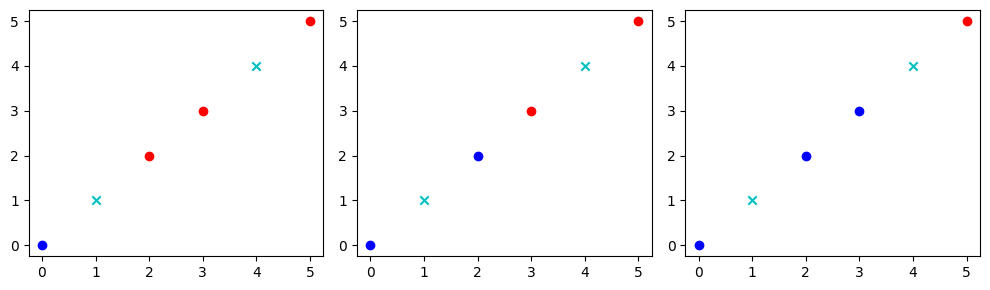

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

kmeans.update(c=[[0,0],[2,2]])
kmeans.forward(verbose=False, ax=ax[0])

kmeans.update(c=[[2,2],[3,3]])
kmeans.forward(verbose=False, ax=ax[1])

kmeans.update(c=[[3,3],[5,5]])
kmeans.forward(verbose=False, ax=ax[2])

plt.tight_layout()
plt.show()

可以看出来这三个选取点，产生了完全不一样的结果，所以 K-Means 算法是有局部最优特性的